# Industrial Sensor Tag Comparison using RAG with LLM

In [5]:
import PyPDF2

In [6]:
!pip install langchain pdfplumber faiss-cpu pandas matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.0/408.0 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.9/296.9 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.

In [7]:
pip install langchain_huggingface

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 3.6 MB/s eta 0:00:00


In [8]:
pip install langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.9 MB/s eta 0:00:00


In [9]:
pip install langchain_groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 3.7 MB/s eta 0:00:00


In [10]:
import pdfplumber
import pandas as pd
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains import RetrievalQA
import matplotlib.pyplot as plt


# Data Parsing

In [12]:
pg_tags_pdf = open('PG_TAGS.pdf', 'rb')
vq_tags_pdf = open('VQ_TAGS.pdf', 'rb')

In [13]:
def parse_pdf_to_df(pdf_path):
    # Function to parse a PDF file and convert it into a DataFrame
    data = []
    with pdfplumber.open(pdf_path) as pdf:
        columns = ['S.No', 'Tag Number', 'Calibration Min','Calibration Max','Operating Min','Operating Max','Range Kg/Cm²','Qty','Unit Prices']
        for page in pdf.pages:

            table = page.extract_table()
            if len(table[0])>6:
              return pd.DataFrame(table,columns=columns)
            else:
              return pd.DataFrame(table,columns=['Tag Number', 'Calibration Min','Calibration Max','Operating Min','Operating Max','Range Kg/Cm²'])

# Open and read PDF files
pg_tags_pdf = open('PG_TAGS.pdf', 'rb')
vq_tags_pdf = open('VQ_TAGS.pdf', 'rb')

# Parse each PDF document
df_pg_tags = parse_pdf_to_df(pg_tags_pdf)
df_vq_tags = parse_pdf_to_df(vq_tags_pdf)


In [14]:
def data_preprocessing(data):
  data = data[2:]
  data = data.reset_index()
  data = data.drop(columns=['index'])
  data['Calibration Range'] = "(" + data['Calibration Min'] + "," + data['Calibration Max']+ ")"
  data['Operating Range'] = "(" + data['Operating Min'] + "," + data['Operating Max']+ ")"
  data.drop(columns=['Calibration Min','Calibration Max','Operating Min','Operating Max'],inplace=True)
  if data.shape[1]>8:
    data.drop(columns=['S.No'],inplace=True)

    return data
  else:
    return data



In [15]:
df_pg_tags = data_preprocessing(df_pg_tags)
df_vq_tags = data_preprocessing(df_vq_tags)

In [16]:
df_pg_tags.head(10)

,Tag Number,Range Kg/Cm²,Calibration Range,Operating Range
0,PI-02,0-4,"(0,3)","(0,1.2)"
1,PI-03,0-4,"(0,3)","(0,1.2)"
2,PI-04,0-4,"(0,3)","(0,1.2)"
3,PI-09,0-1,"(0,1)","(,)"
4,PI-10,0-1,"(0,1)","(,)"
5,PI-06A,0-1,"(0,1)","(,)"
6,PI-06B,0-1,"(0,1)","(,)"


In [17]:
df_vq_tags.head(10)

,S.No,Tag Number,Range Kg/Cm²,Qty,Unit Prices,Calibration Range,Operating Range
0,1,PI-02,0 – 4,01 No.,6800,"(0,3)","(0,1.2)"
1,2,PI-03,0 – 4,01 No.,6800,"(0,5)","(0,1.2)"
2,3,PI-04,0 – 4,01 No.,6800,"(0,3)","(0,1.2)"
3,4,PI-09,0 – 1,01 No.,2100,"(0,2)","(,)"
4,5,PI-10,0 – 1,01 No.,2100,"(0,1)","(,)"
5,6,PI-06A,0 – 1,01 No.,2100,"(0,1)","(,)"
6,7,PI-06B,0 – 1,01 No.,2100,"(0,1)","(,)"
7,8,PI-08A,0 – 2.5,01 No.,6800,"(0,2)","(0,1.1)"
8,9,PI-08B,0 – 2.5,01 No.,6800,"(0,2)","(0,1.1)"
9,10,PI-08C,0 – 2.5,01 No.,6800,"(0,2)","(0,1.1)"


# Comparision Logic

In [18]:
def compare_documents(df_pg, df_vq):
    matching_tags = []
    discrepancies = []
    concerns = []

    # Check for matching tags and discrepancies
    for _, row_pg in df_pg.iterrows():
        tag_pg = row_pg['Tag Number']
        calibration_pg = row_pg['Calibration Range']
        operating_pg = row_pg['Operating Range']

        # Search for the tag in the vendor quotation
        row_vq = df_vq[df_vq['Tag Number'] == tag_pg]

        if not row_vq.empty:
            row_vq = row_vq.iloc[0]  # Get the first matching row
            calibration_vq = row_vq['Calibration Range']
            operating_vq = row_vq['Operating Range']

            if calibration_pg == calibration_vq and operating_pg == operating_vq:
                matching_tags.append({
                    "Tag Number": tag_pg,
                    "Calibration Range": calibration_pg,
                    "Operating Range": operating_pg
                })
            else:
                discrepancies.append({
                    "Tag Number": tag_pg,
                    "Calibration PG": calibration_pg,
                    "Calibration VQ": calibration_vq,
                    "Operating Range PG": operating_pg,
                    "Operating Range VQ": operating_vq
                })
        else:
            concerns.append({
                "Tag Number": tag_pg,
                "Calibration Range": calibration_pg,
                "Operating Range": operating_pg,
                "Issue": "Missing in VQ document"
            })

    return matching_tags, discrepancies, concerns




We have created a function for the comparision logic to find Matching tags, Discrepancies and Concerns

In [19]:
# Perform the comparison
matching_tags, discrepancies, concerns = compare_documents(df_pg_tags, df_vq_tags)

# Visualization

In [20]:
# Convert results to DataFrames for structured output
df_matching = pd.DataFrame(matching_tags)
df_discrepancies = pd.DataFrame(discrepancies)
df_concerns = pd.DataFrame(concerns)

# Print structured outputs
print("Matching Tags:\n", df_matching)
print("\nDiscrepancies:\n", df_discrepancies)
print("\nConcerns:\n", df_concerns)

Matching Tags:
   Tag Number Calibration Range Operating Range
0      PI-02             (0,3)         (0,1.2)
1      PI-04             (0,3)         (0,1.2)
2      PI-10             (0,1)             (,)
3     PI-06A             (0,1)             (,)
4     PI-06B             (0,1)             (,)

Discrepancies:
   Tag Number Calibration PG Calibration VQ Operating Range PG  \
0      PI-03          (0,3)          (0,5)            (0,1.2)   
1      PI-09          (0,1)          (0,2)                (,)   

  Operating Range VQ  
0            (0,1.2)  
1                (,)  

Concerns:
 Empty DataFrame
Columns: []
Index: []


Created a function that help to visualize the values of Matching Tags, Discrepancies and concerns

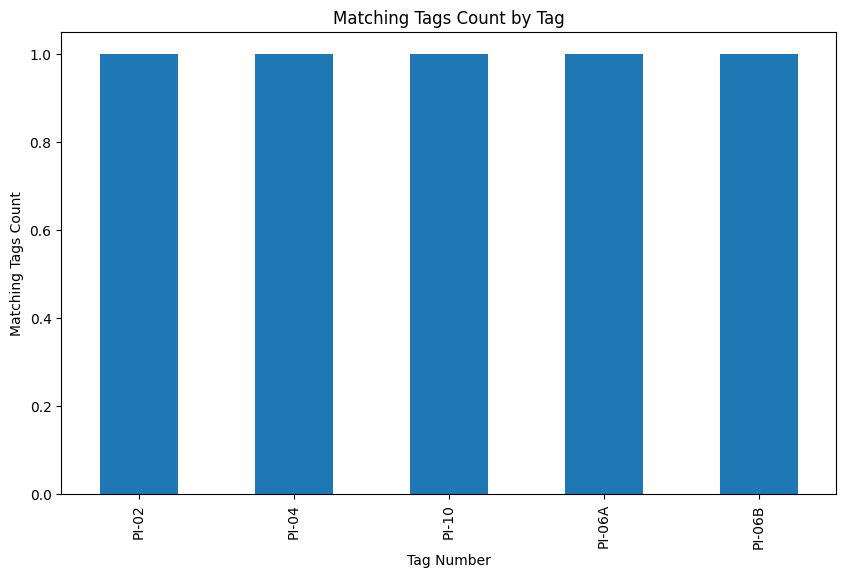

In [21]:
# Visualization (optional)
def visualize_Tags(df,tag_type):
    if not df.empty:
        plt.figure(figsize=(10, 6))
        plt.title( tag_type + " Count by Tag")
        df['Tag Number'].value_counts().plot(kind='bar')
        plt.xlabel("Tag Number")
        plt.ylabel(tag_type + " Count")
        plt.show()

visualize_Tags(df_matching,"Matching Tags")

 Our logic is working properly. Now the same logic we need to integrate in our LLM model.   
 1) firstly we need to perform convert the data into the format that to be understandable by LLM model for that I am just convreting the dictionary into an textual data  

2) Use text data as RAG source and integrate it with our LLM model. for LLM model I am using LLama3 through Groq API.

Note: Not using text embedding and vector stores as vector similarity not able to identifies descrepencies and giving a wrong result

In [37]:
from langchain_groq import ChatGroq
from google.colab import userdata
from langchain import  LLMChain, PromptTemplate

# Define a prompt template
prompt_template = """
You are analyzing a comparison of industrial sensor tags between two documents.
Please provide a summary based on the following information:

Matching Tags:
{matching_tags}

Discrepancies:
{discrepancies}

Concerns:
{concerns}

Please provide a detailed summary describing:
1. The matching tags with values.
2. The discrepancies, specifying which fields have different values.
3. The concerns, including any missing tags or issues detected.
"""

prompt = PromptTemplate(
    input_variables=["matching_tags", "discrepancies", "concerns"],
    template=prompt_template
)

In [38]:
# Prepare formatted inputs for the LLM
formatted_matching = "\n".join([f"Tag: {m['Tag Number']}, Calibration Range: {m['Calibration Range']}, Operating Range: {m['Operating Range']}" for m in matching_tags])
formatted_discrepancies = "\n".join([f"Tag: {d['Tag Number']}, Calibration PG: {d['Calibration PG']}, Calibration VQ: {d['Calibration VQ']}, Operating Range PG: {d['Operating Range PG']}, Operating Range VQ: {d['Operating Range VQ']}" for d in discrepancies])
formatted_concerns = "\n".join([f"Tag: {c['Tag Number']}, Calibration Range: {c['Calibration Range']}, Operating Range: {c['Operating Range']}, Issue: {c['Issue']}" for c in concerns])


In [39]:
groq_api_key = userdata.get('GROQ_API_KEY')
# Initialize LLM
llm = ChatGroq(groq_api_key=groq_api_key,model_name="Llama-3.1-70b-versatile")

# Initialize LLM chain
llm_chain = LLMChain(prompt=prompt, llm=llm)

# Run LLM with the comparison results to generate a summary
summary = llm_chain.run({
    "matching_tags": formatted_matching,
    "discrepancies": formatted_discrepancies,
    "concerns": formatted_concerns
})

print("Comparison Summary:\n", summary)


<ipython-input-39-e0e8923d3da7>:6: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  llm_chain = LLMChain(prompt=prompt, llm=llm)
<ipython-input-39-e0e8923d3da7>:9: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  summary = llm_chain.run({


Comparison Summary:
 **Summary of Industrial Sensor Tags Comparison**

**Matching Tags:**

A total of 5 tags have matching information between the two documents. These tags are:

- Tag: PI-02, with a calibration range of (0,3) and an operating range of (0,1.2)
- Tag: PI-04, with a calibration range of (0,3) and an operating range of (0,1.2)
- Tag: PI-10, with a calibration range of (0,1) but no specified operating range
- Tag: PI-06A, with a calibration range of (0,1) but no specified operating range
- Tag: PI-06B, with a calibration range of (0,1) but no specified operating range

**Discrepancies:**

Two tags have discrepancies in their information between the two documents.

- Tag: PI-03, has discrepancies in the following fields:
  - Calibration Range: PG document shows (0,3) while VQ document shows (0,5)
  - Although the operating ranges in both documents are (0,1.2), it is unclear if the discrepancy lies in the calibration ranges only.
- Tag: PI-09, has discrepancies in the follow

##Result
The output summary will contain a human-readable description of:

Matching Tags: Tags with matching values in both documents.

Discrepancies: Tags with differing values, with specifics on which fields have mismatched data.

Concerns: Tags missing in one document or flagged with other issues.

This RAG-based approach provides a comprehensive way to analyze and describe matching tag, discrepancies and concerns, giving users clear insight into data differences.